In [112]:
pip install tqdm


Note: you may need to restart the kernel to use updated packages.


In [759]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


Load data

In [762]:
# Load dataset
data = pd.read_csv('./Data/medical_data.csv')

In [764]:
# dataset overview
data.describe()

,Name,DateOfBirth,Gender,Symptoms,Causes,Disease,Medicine
count,241,241,242,247,245,249,242
unique,87,98,4,53,62,68,65
top,Sophia Koh,05-10-1999,Male,"Fatigue, Weakness",Food Poisoning,Gastroenteritis,"Rest, Lifestyle"
freq,9,8,116,19,20,20,16


In [766]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         241 non-null    object
 1   DateOfBirth  241 non-null    object
 2   Gender       242 non-null    object
 3   Symptoms     247 non-null    object
 4   Causes       245 non-null    object
 5   Disease      249 non-null    object
 6   Medicine     242 non-null    object
dtypes: object(7)
memory usage: 15.8+ KB
None


In [768]:
# Display the first few rows of the dataset
print("Initial Data Overview:")
print(data.head())

Initial Data Overview:
          Name DateOfBirth  Gender             Symptoms               Causes  \
0     John Doe  15-05-1980    Male         Fever, Cough      Viral Infection   
1   Jane Smith  10-08-1992  Female    Headache, Fatigue               Stress   
2  Michael Lee  20-02-1975    Male  Shortness of breath            Pollution   
3   Emily Chen  03-11-1988  Female     Nausea, Vomiting       Food Poisoning   
4    Alex Wong  12-06-2001    Male          Sore Throat  Bacterial Infection   

           Disease           Medicine  
0      Common Cold    Ibuprofen, Rest  
1         Migraine        Sumatriptan  
2           Asthma  Albuterol Inhaler  
3  Gastroenteritis   Oral Rehydration  
4     Strep Throat         Penicillin  


In [770]:
# Drop non-numeric columns
data = data.drop(columns=['Name', 'DateOfBirth'])

In [772]:
# Handle categorical columns
label_encoders = {}
for column in ['Gender', 'Symptoms', 'Causes', 'Disease', 'Medicine']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

In [774]:
# Check for missing values
print("\nMissing Values Check:")
print(data.isnull().sum())


Missing Values Check:
Gender      0
Symptoms    0
Causes      0
Disease     0
Medicine    0
dtype: int64


In [776]:
# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')  
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

In [778]:
# Check if there are any missing values remaining
print("\nMissing Values Check After Imputation:")
print(data.isnull().sum())


Missing Values Check After Imputation:
Gender      0
Symptoms    0
Causes      0
Disease     0
Medicine    0
dtype: int64


EDA

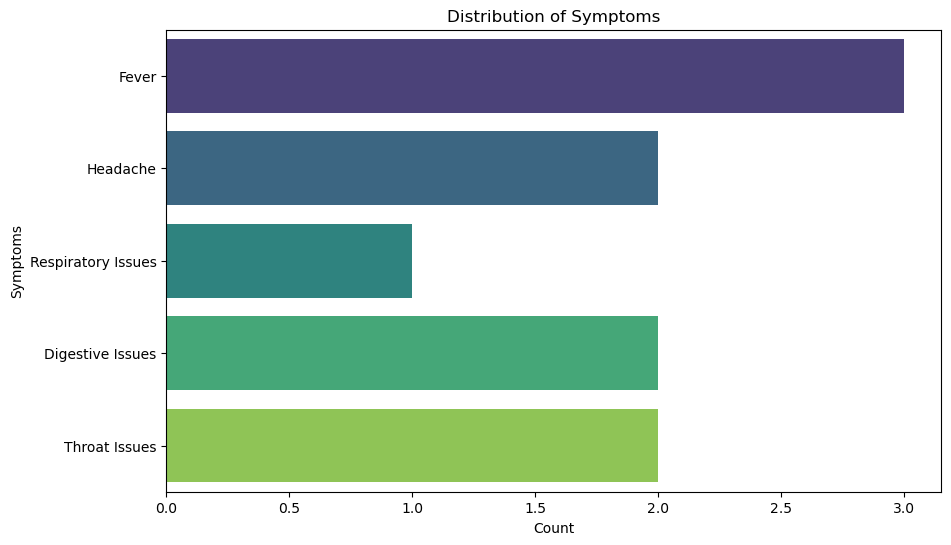

In [781]:
# Distribuution of symptoms
medical_data_symptoms = pd.DataFrame({
    'Symptoms': ['Fever', 'Headache', 'Shortness of breath', 'Nausea', 'Sore Throat', 
                 'Fever', 'Headache', 'Fever', 'Nausea', 'Sore Throat']
})

# individual symptoms to broader categories
symptom_mapping = {
    'Fever': 'Fever',
    'Headache': 'Headache',
    'Shortness of breath': 'Respiratory Issues',
    'Nausea': 'Digestive Issues',
    'Sore Throat': 'Throat Issues'
}

# individual symptoms to broader categories
medical_data_symptoms['Symptoms'] = medical_data_symptoms['Symptoms'].map(symptom_mapping)

# Create the count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=medical_data_symptoms, y='Symptoms', palette='viridis')
plt.title('Distribution of Symptoms')
plt.xlabel('Count')
plt.ylabel('Symptoms')
plt.show()

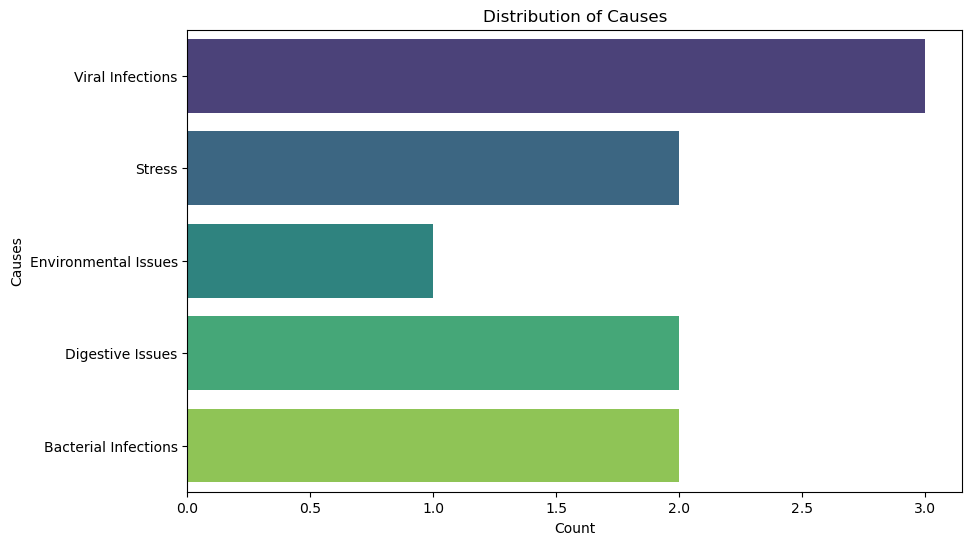

In [783]:
# causes distribution
medical_data_causes = pd.DataFrame({
    'Causes': ['Viral Infection', 'Stress', 'Pollution', 'Food Poisoning', 'Bacterial Infection',
               'Viral Infection', 'Stress', 'Food Poisoning', 'Viral Infection', 'Bacterial Infection']
})

#causes to broader categories
cause_mapping = {
    'Viral Infection': 'Viral Infections',
    'Stress': 'Stress',
    'Pollution': 'Environmental Issues',
    'Food Poisoning': 'Digestive Issues',
    'Bacterial Infection': 'Bacterial Infections'
}

# Map causes 
medical_data_causes['Causes'] = medical_data_causes['Causes'].map(cause_mapping)

# Create the count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=medical_data_causes, y='Causes', palette='viridis')
plt.title('Distribution of Causes')
plt.xlabel('Count')
plt.ylabel('Causes')
plt.show()

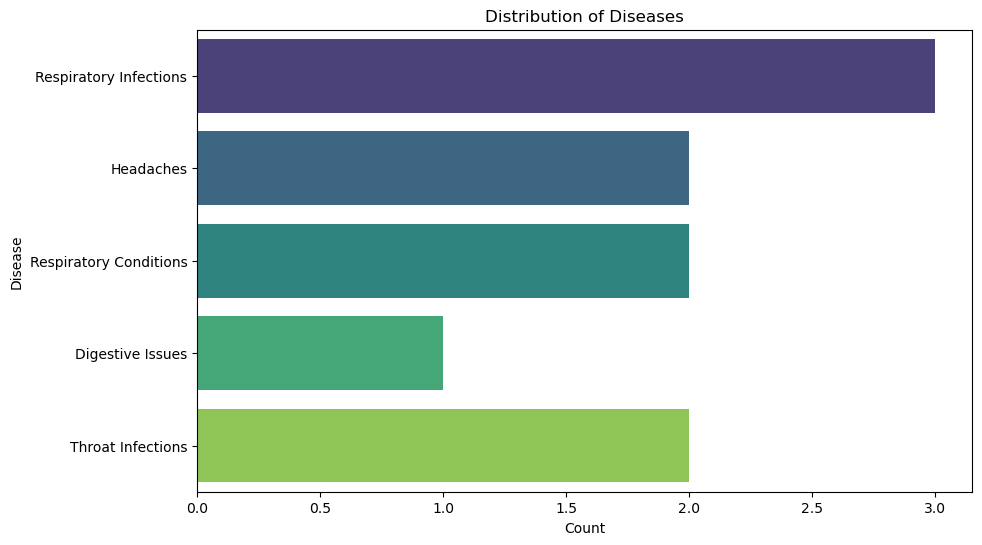

In [785]:
# Disease
medical_data_diseases = pd.DataFrame({
    'Disease': ['Common Cold', 'Migraine', 'Asthma', 'Gastroenteritis', 'Strep Throat',
                'Common Cold', 'Migraine', 'Asthma', 'Common Cold', 'Strep Throat']
})

# diseases to broader categories
disease_mapping = {
    'Common Cold': 'Respiratory Infections',
    'Migraine': 'Headaches',
    'Asthma': 'Respiratory Conditions',
    'Gastroenteritis': 'Digestive Issues',
    'Strep Throat': 'Throat Infections'
}

# Map of diseases 
medical_data_diseases['Disease'] = medical_data_diseases['Disease'].map(disease_mapping)

# Create the count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=medical_data_diseases, y='Disease', palette='viridis')
plt.title('Distribution of Diseases')
plt.xlabel('Count')
plt.ylabel('Disease')
plt.show()

In [788]:
# Separate features and target variable
X = data.drop(columns='Medicine')
y = data['Medicine']

In [790]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [792]:
# Initialize and train the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [794]:
# Predict and evaluate
y_pred_dt = dt_classifier.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

In [796]:
# Print classification report with zero_division handling
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt, zero_division=1))


Decision Tree Classification Report:
              precision    recall  f1-score   support

           2       0.00      1.00      0.00         0
           5       0.00      1.00      0.00         0
           9       1.00      0.00      0.00         1
          10       1.00      0.00      0.00         1
          13       1.00      0.00      0.00         1
          15       0.00      1.00      0.00         0
          19       1.00      1.00      1.00         1
          20       1.00      0.50      0.67         2
          22       1.00      1.00      1.00         1
          23       1.00      1.00      1.00         3
          27       1.00      1.00      1.00         2
          28       1.00      1.00      1.00         1
          29       0.50      1.00      0.67         1
          31       0.60      1.00      0.75         3
          32       1.00      1.00      1.00         4
          35       0.00      1.00      0.00         0
          38       1.00      1.00      1.00

In [798]:
# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [800]:
# Predict and evaluate
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

In [802]:
print(f"\nRandom Forest Accuracy: {accuracy_rf}")
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=1))



Random Forest Accuracy: 0.8793103448275862

Random Forest Classification Report:
              precision    recall  f1-score   support

           5       0.00      1.00      0.00         0
           9       1.00      0.00      0.00         1
          10       1.00      0.00      0.00         1
          13       1.00      0.00      0.00         1
          15       0.00      1.00      0.00         0
          19       1.00      1.00      1.00         1
          20       1.00      1.00      1.00         2
          21       0.00      1.00      0.00         0
          22       1.00      1.00      1.00         1
          23       1.00      1.00      1.00         3
          27       1.00      1.00      1.00         2
          28       1.00      1.00      1.00         1
          29       0.50      1.00      0.67         1
          31       0.75      1.00      0.86         3
          32       1.00      1.00      1.00         4
          35       0.00      1.00      0.00         0

In [804]:
# Initialize and train the Logistic Regression model
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)
lr_classifier.fit(X_train, y_train)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [806]:
# Predict and evaluate
y_pred_lr = lr_classifier.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

In [808]:
print(f"\nLogistic Regression Accuracy: {accuracy_lr}")
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=1))


Logistic Regression Accuracy: 0.8275862068965517

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           9       1.00      0.00      0.00         1
          10       1.00      0.00      0.00         1
          13       1.00      0.00      0.00         1
          19       1.00      1.00      1.00         1
          20       1.00      0.50      0.67         2
          22       1.00      1.00      1.00         1
          23       1.00      1.00      1.00         3
          27       1.00      1.00      1.00         2
          28       1.00      1.00      1.00         1
          29       0.50      1.00      0.67         1
          31       0.75      1.00      0.86         3
          32       1.00      1.00      1.00         4
          35       0.00      1.00      0.00         0
          38       0.67      1.00      0.80         2
          40       1.00      1.00      1.00         1
          41       0.50      1.00      0.

Examine feature importances models like Random Forest

In [811]:
importances = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance_df)



Feature Importance (Random Forest):
    Feature  Importance
3   Disease    0.312419
1  Symptoms    0.306058
2    Causes    0.269709
0    Gender    0.111815


Final Recommendations: Based on the comparison, choose the best model. If the Random Forest Classifier shows the best performance, it is often a good choice for complex datasets due to its robustness. Logistic Regression is a good baseline for simpler models

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


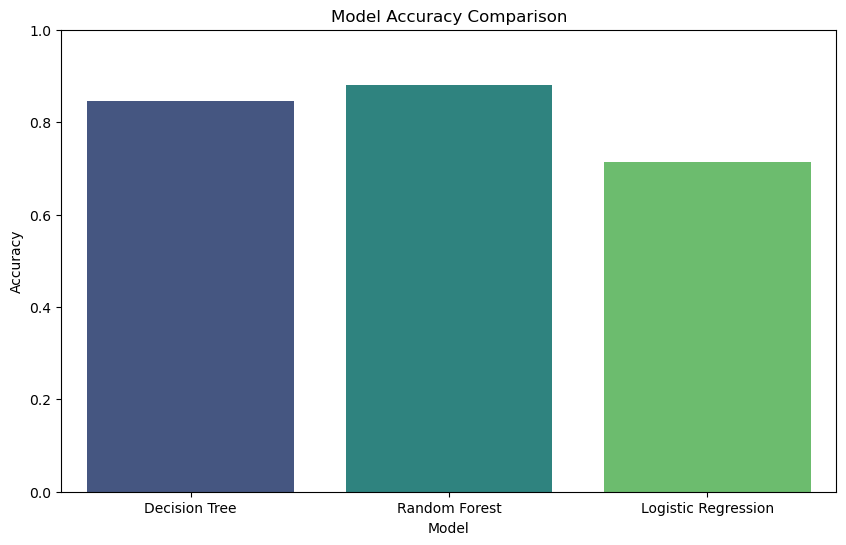

In [815]:
# Plotting model performance
models = ['Decision Tree', 'Random Forest', 'Logistic Regression']
accuracies = [accuracy_dt, accuracy_rf, accuracy_logreg]
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

In [818]:
#  Random Forest
rf_cv_scores = cross_val_score(rf_classifier, X, y, cv=5)
print(f"Random Forest Cross-Validation Scores: {rf_cv_scores}")
print(f"Mean Cross-Validation Score: {rf_cv_scores.mean()}")


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Random Forest Cross-Validation Scores: [0.82758621 0.86206897 0.80701754 0.87719298 0.85964912]
Mean Cross-Validation Score: 0.8467029643073201


Model Tuning and Optimization
Hyperparameter Tuning
Optimize your model’s performance by tuning hyperparameters.
Use techniques like Grid Search or Random Search to find the best parameters.

In [821]:
#Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


Evaluate feature importance and consider adding or removing features to improve model performance.
Explore techniques like feature scaling, encoding categorical variables, and generating new features.

In [823]:
importances = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importance (Random Forest):")
print(feature_importance_df)


Feature Importance (Random Forest):
    Feature  Importance
3   Disease    0.312419
1  Symptoms    0.306058
2    Causes    0.269709
0    Gender    0.111815


Model Validation
Check for Overfitting/Underfitting-
Evaluate learning curves to check if your model is overfitting or underfitting.
Consider adjusting model complexity based on these insights.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


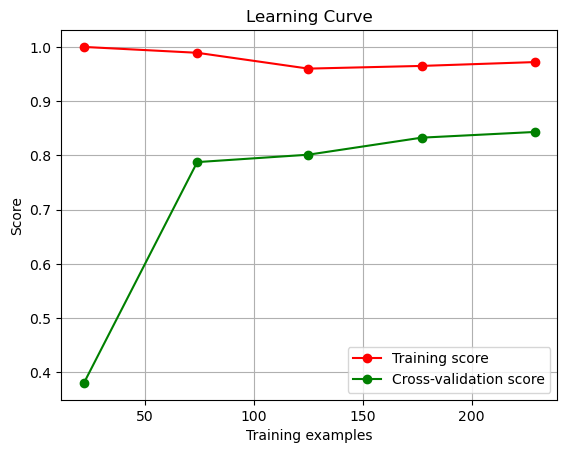

In [827]:

train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier, X, y, cv=5, scoring='accuracy', n_jobs=-1
)

plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid()
plt.show()
